In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./results/all_results-all_results.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 128 non-null    object 
 1   context_set_id        128 non-null    int64  
 2   dataset               128 non-null    object 
 3   context_size          128 non-null    int64  
 4   accuracy_teacher      128 non-null    float64
 5   accuracy_indomain     128 non-null    float64
 6   accuracy_ood          128 non-null    float64
 7   trainable_parameters  128 non-null    int64  
 8   all_parameters        128 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 9.1+ KB


In [3]:
def plot_row_by_func(plot_func, datasets, titles, main_title=None, filename=None, legend_order=None):
    fig, axs = plt.subplots(1, len(datasets), figsize=(len(datasets)*6, 6))
    for dataset, ax, title in zip(datasets, axs, titles):
        plot_func(dataset, ax, title, legend_order)
    plt.tight_layout()
    if main_title:
        fig.text(0.01, 0.5, main_title, fontsize=22, va='center', rotation='vertical')
        plt.subplots_adjust(left=0.095)
    if filename:
        fig.savefig(f'{main_title}_{filename}')
    plt.show()
    return fig

## In-domain vs Out-of-domain accuracy

In [4]:
def plot_accuracy(dataset, ax, title=None, legend_order='auto'):
    sns.set_theme(style="whitegrid")
    g = sns.scatterplot(
        data=dataset,
        x="accuracy_indomain",
        y="accuracy_ood",
        hue="model",
        ax=ax,
        s=250,
        hue_order=legend_order
    )
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
    ax.set_xlim(0.4, 0.9)
    ax.set_ylim(0.4, 0.9)
    ax.set_xlabel("in-domain accuracy", fontsize=18)
    ax.set_ylabel("out-of-domain accuracy", fontsize=18)
    ax.set_title(title, fontsize=20)
    ax.tick_params(labelsize=16)
    return g

legend_order = [
    'opt-125m',
    'opt-350m',
    'opt-1.3b',
    'opt-2.7b'
]

### By benchmark dataset

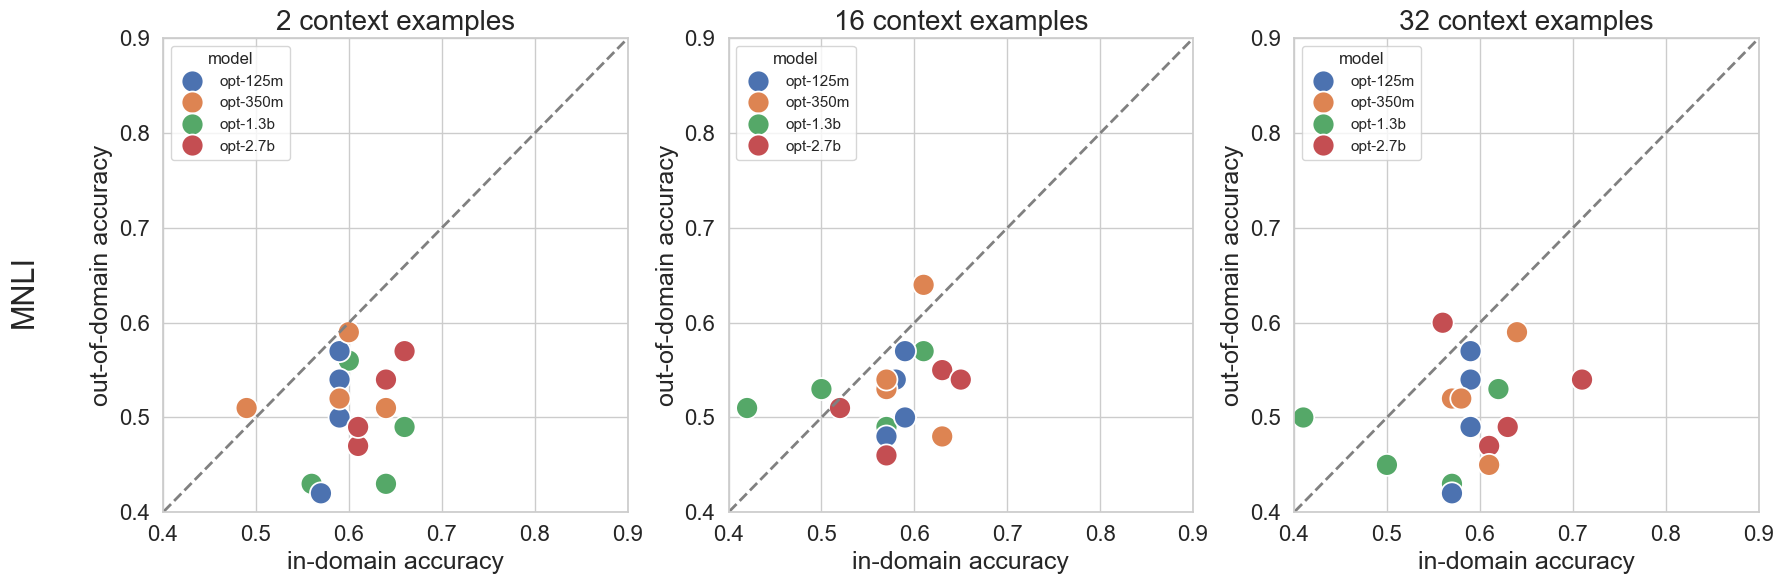

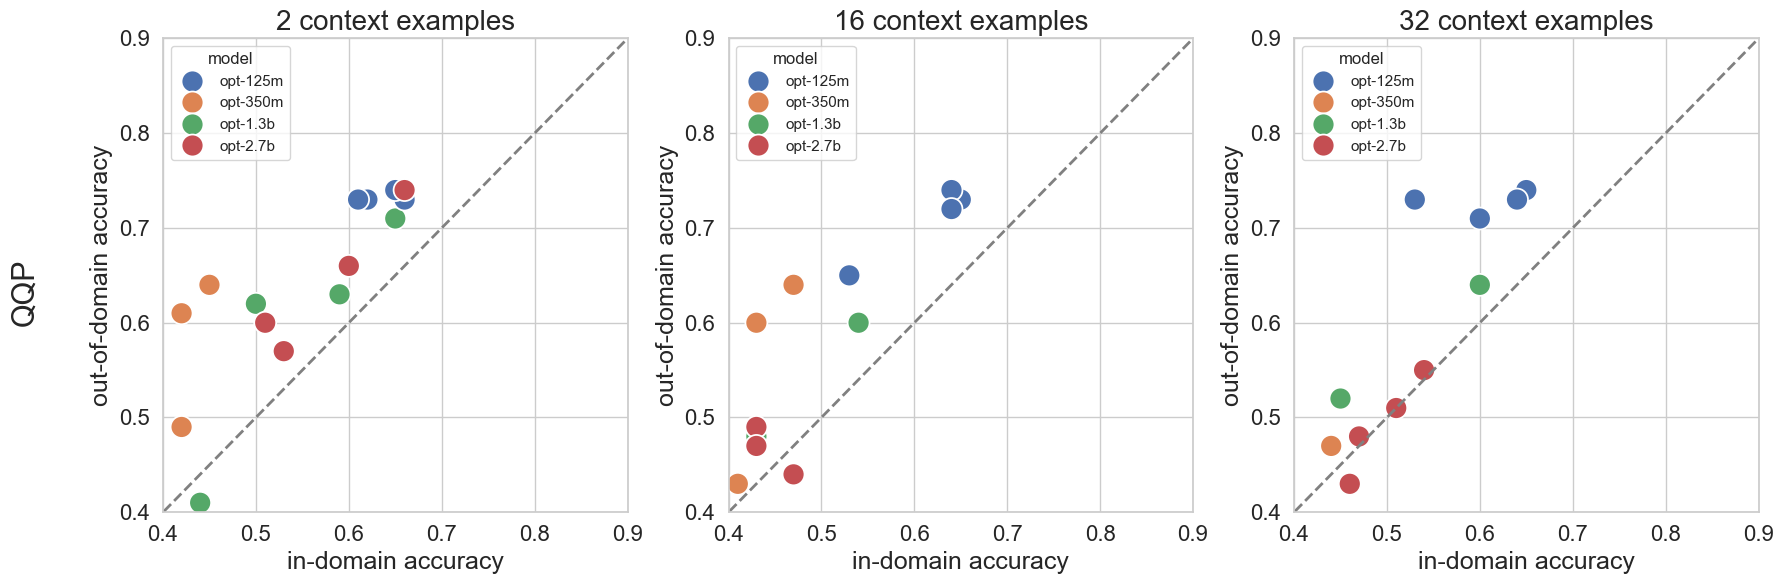

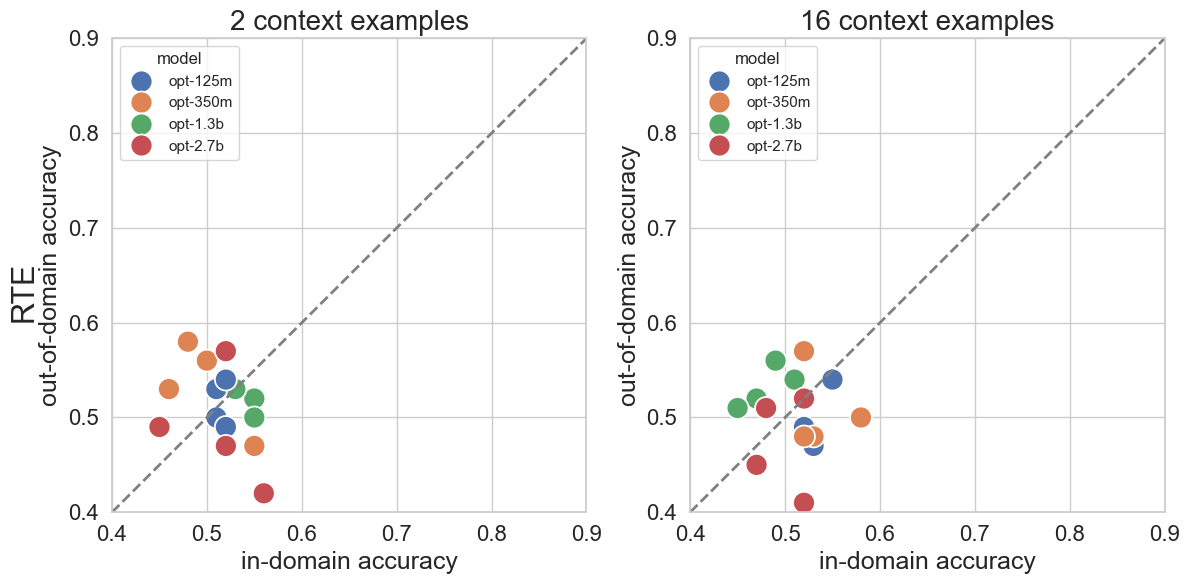

In [12]:
benchmarks = [
    ('mnli', [2, 16, 32]),
    ('qqp', [2, 16, 32]), 
    ('rte', [2, 16])
]
for bm, ce in benchmarks:
    datasets = [data[(data['dataset'] == bm) & (data['context_size'] == n)] for n in ce]
    titles = [f'{n} context examples' for n in ce]
    plot_row_by_func(
        plot_accuracy,
        datasets,
        titles,
        bm.upper(),
        'context_examples.png',
        legend_order
    )

### By task

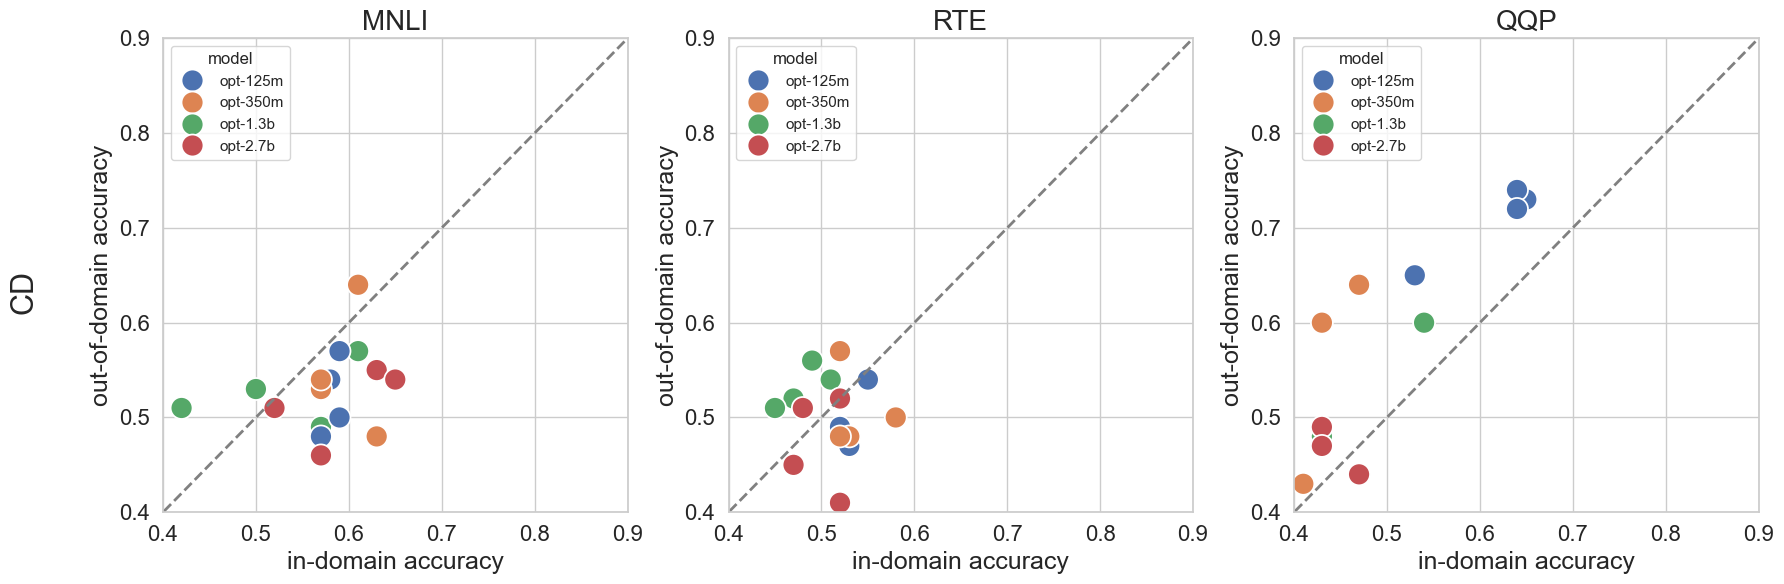

In [13]:
benchmarks = [
    (16, ['mnli', 'rte', 'qqp']),
]
for bm, ce in benchmarks:
    datasets = [data[(data['context_size'] == bm) & (data['dataset'] == n)] for n in ce]
    titles = [f'{n.upper()}' for n in ce]
    plot_row_by_func(
        plot_accuracy,
        datasets,
        titles,
        'CD',
        'per_benchmark_set.png',
        legend_order
    )

## Quality of learning

In [7]:
# Group the results to get a mean for further comparasion
aggs = 'mean'
ave_results = data.groupby(
    ['model', 'dataset', 'context_size']
).agg({
    'accuracy_teacher': aggs,
    'accuracy_indomain': aggs,
    'accuracy_ood': aggs,
    'trainable_parameters': 'max',
    'all_parameters': 'max',
}).reset_index()

ave_results.sort_values(by=['model', 'dataset', 'context_size'], inplace=True)
ave_results['model'] = ave_results['model'].apply(lambda x: x.split('-')[1])

In [8]:
def plot_accuracy_bars(dataset, ax, title=None, legend_order='auto'):
    df_melt = dataset.melt(id_vars='model', value_vars=['accuracy_teacher', 'accuracy_indomain', 'accuracy_ood'])
    g = sns.barplot(data=df_melt, x='model', y='value', hue='variable', ax=ax, errorbar=None)
    ax.set_ylim(0.0, 0.8)
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(title or 'Accuracy by Model')
    ax.legend(title='Accuracy Type', loc='lower right')
    return g

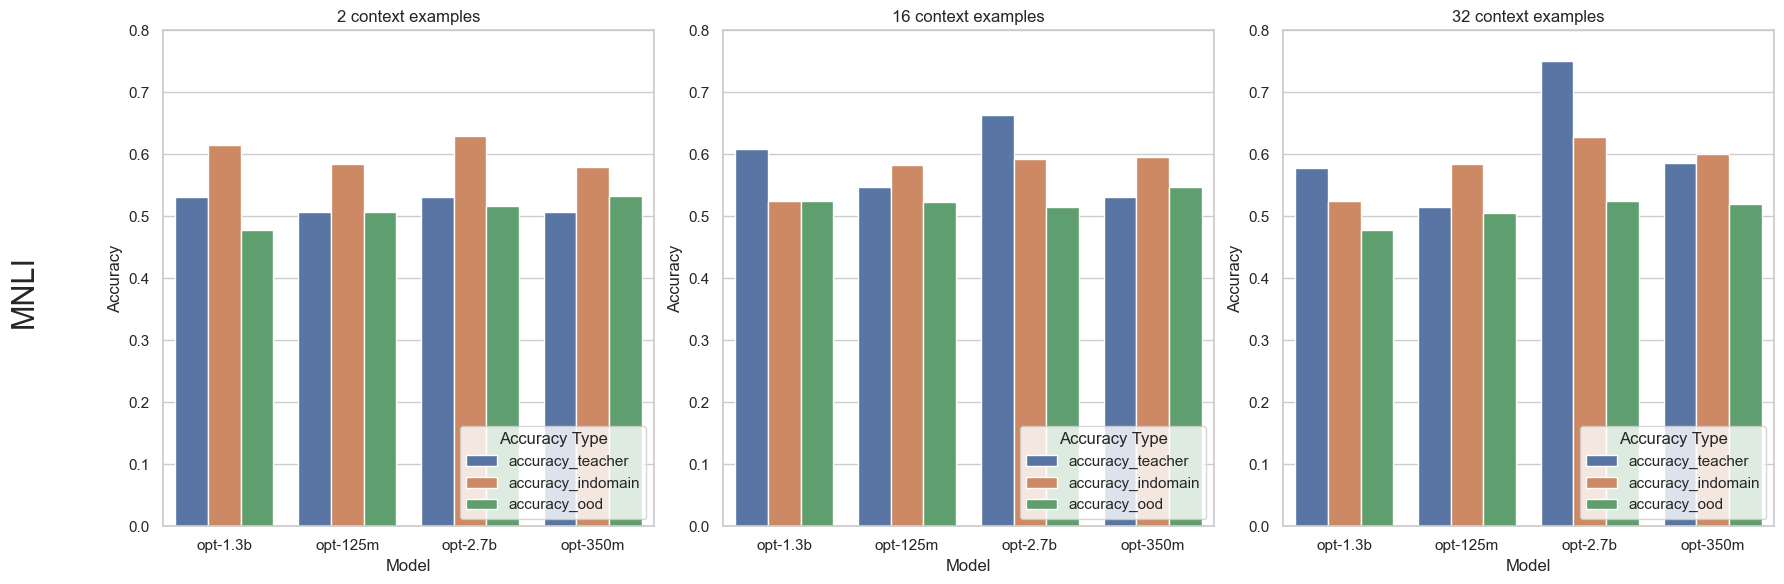

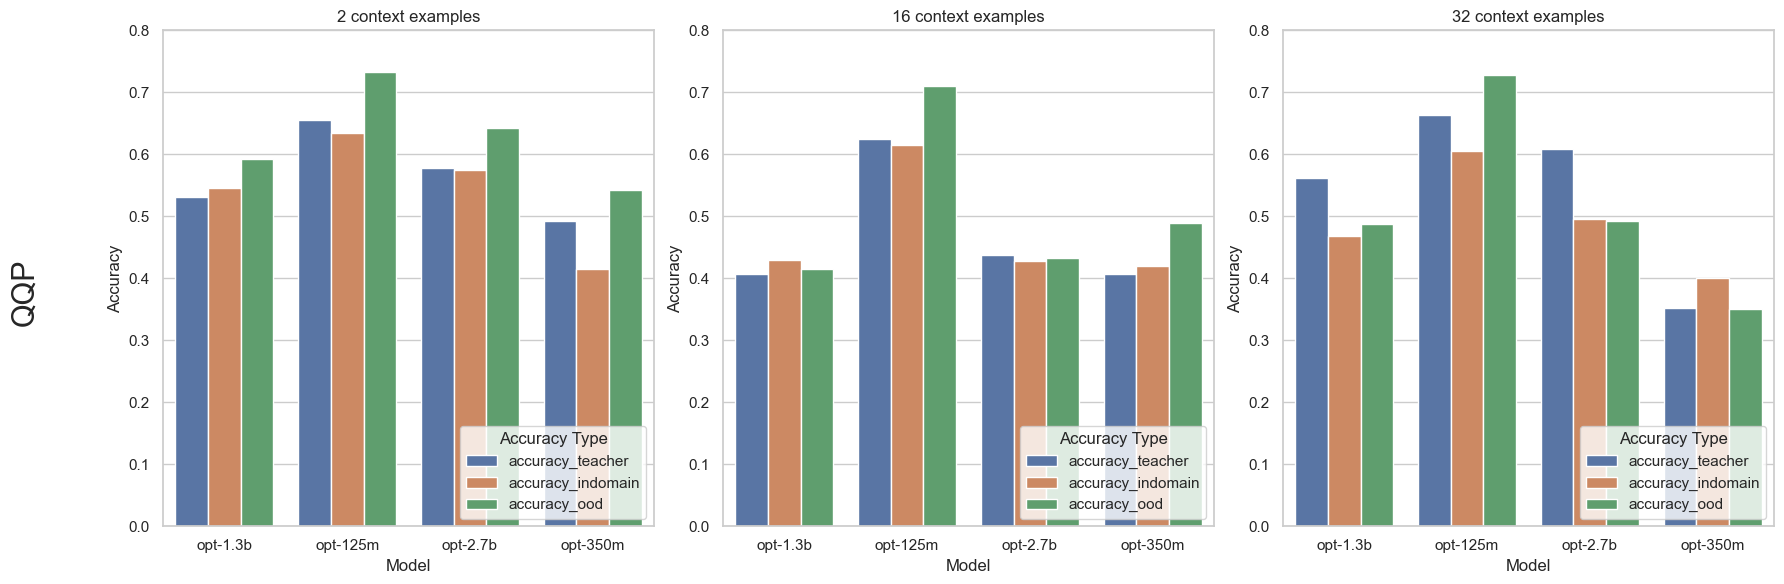

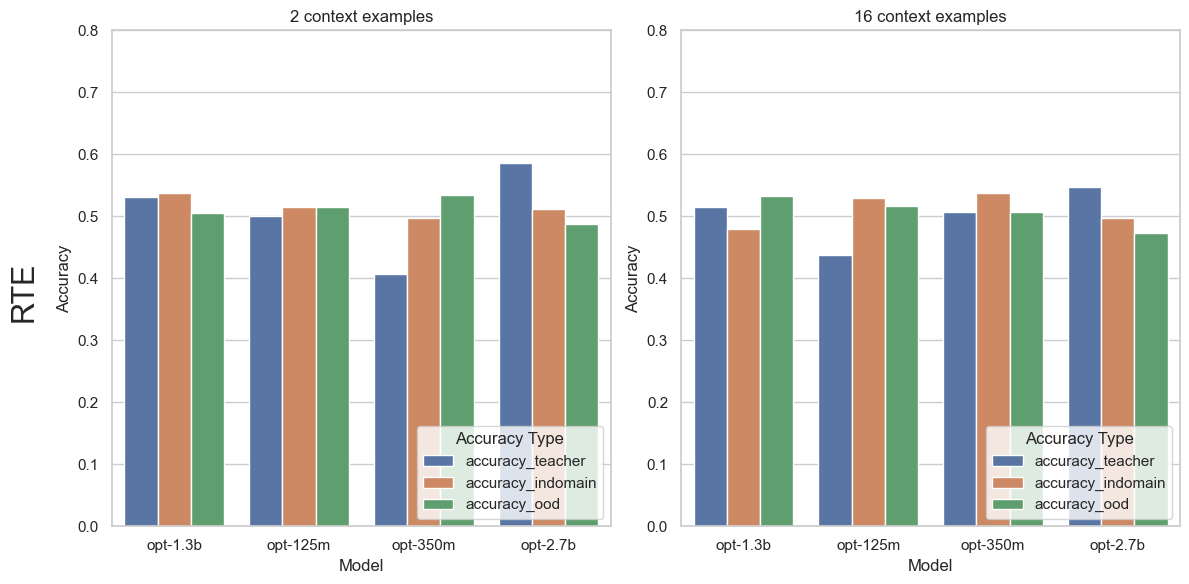

In [9]:
benchmarks = [
    ('mnli', [2, 16, 32]),
    ('qqp', [2, 16, 32]), 
    ('rte', [2, 16])
]
for bm, ce in benchmarks:
    datasets = [data[(data['dataset'] == bm) & (data['context_size'] == n)] for n in ce]
    titles = [f'{n} context examples' for n in ce]
    plot_row_by_func(
        plot_accuracy_bars,
        datasets,
        titles,
        bm.upper(),
        'accuracy_comparisons.png',
        legend_order
    )

In [10]:
# Put data in order for each table creation
n16 = ave_results[ave_results['context_size'] == 16]

# Set order so that models are in order from 125m to 2.7b
n16['order'] = 0
n16['order'][n16['model'] == '125m'] = 1
n16['order'][n16['model'] == '350m'] = 2
n16['order'][n16['model'] == '1.3b'] = 3
n16['order'][n16['model'] == '2.7b'] = 4

n16.sort_values(by=['dataset', 'order'], inplace=True)

table_df = n16[['dataset', 'model', 'accuracy_teacher', 'accuracy_indomain', 'accuracy_ood']]
table_df.to_csv('./results/table_data.csv', index=False)

/var/folders/2g/ns6nrmt5213f_41kxwb3dtjh0000gn/T/ipykernel_26258/1586909231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n16['order'] = 0
/var/folders/2g/ns6nrmt5213f_41kxwb3dtjh0000gn/T/ipykernel_26258/1586909231.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc

In [11]:
n16

,model,dataset,context_size,accuracy_teacher,accuracy_indomain,accuracy_ood,trainable_parameters,all_parameters,order
9,125m,mnli,16,0.546875,0.5825,0.5225,589824,125829120,1
25,350m,mnli,16,0.531250,0.5950,0.5475,1572864,332769280,2
1,1.3b,mnli,16,0.609375,0.5250,0.5250,3145728,1318903808,3
17,2.7b,mnli,16,0.664062,0.5925,0.5150,5242880,2656839680,4
12,125m,qqp,16,0.625000,0.6150,0.7100,589824,125829120,1
28,350m,qqp,16,0.406250,0.4200,0.4900,1572864,332769280,2
4,1.3b,qqp,16,0.406250,0.4300,0.4150,3145728,1318903808,3
20,2.7b,qqp,16,0.437500,0.4275,0.4325,5242880,2656839680,4
15,125m,rte,16,0.437500,0.5300,0.5175,589824,125829120,1
31,350m,rte,16,0.507812,0.5375,0.5075,1572864,332769280,2
